In [8]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pyarrow 


# define variables
file_version = ""
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
metropole_appartement_file = "ventes-metropole-appartement" + file_version  + parquet_extension
metropole_maison_file = "ventes-metropole-maison" +  file_version + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_V1_clean_" + parquet_extension

dpe_ranking     = ['0','A','B','C','D','E','F','F/G','G','NS','Unknown']
dpe_ranking_num = [0,1,2,3,4,5,6,7,7,0,0]

#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False
SpiermanDisplay = False

# chauffage système
chauffage_sys =["chauf_sys_climatisation","chauf_sys_radiateur","chauf_sys_pompe_chaleur","chauf_sys_chaudiere","chauf_sys_convecteur","chauf_sys_sol","chauf_sys_poele_bois"]
chauffage_mode =["chauf_mode_individuel","chauf_mode_collectif","chauf_mode_central"]
chauffage_energie =["chauf_energy_fioul","chauf_energy_elec","chauf_energy_gaz","chauf_energy_bois"]
chauffage_systems = chauffage_sys + chauffage_mode + chauffage_energie

# expositions
expositions =['expo_has_nord', 'expo_has_sud', 'expo_has_est', 'expo_has_ouest']

SaveImage = True


# # functions

In [9]:
# functions  

from matplotlib.pylab import Enum

class ColumnType (Enum) :

    NUMERICAL = 1
    CATEGORIAL = 2
    ANY = 3
    LIST = 4

def print_dataframe_isna(df, type = ColumnType.ANY , columns = None) :

    if type == ColumnType.NUMERICAL :
        columns = df.select_dtypes(include='number').columns.tolist()
    elif type == ColumnType.CATEGORIAL :
        columns = df.select_dtypes(include='object').columns.tolist()
    elif type == ColumnType.ANY :
        columns = df.columns.tolist()
    else :
        columns = columns

    percent_missing = df[columns].isnull().sum() * 100 / len(df)
    missing = df[columns].isnull().sum()
    missing_value_df = pd.DataFrame({
                                 'missing values': missing,
                                 'percent_missing': percent_missing})
    print (missing_value_df.sort_values(by="percent_missing",ascending=False))
 

def load_appartement_file () :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file
    return pd.read_parquet(final_path.as_posix())

def save_appartement_file (df) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file_cleaned
    final_path.as_posix
    df.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]

def save_image (plt, filename,modelname, dpi=150) :
    start_path = Path(immo_vis_dir)
    if len(modelname) > 0 :
        final_path = start_path / (filename+ '-' + modelname)
    else :
        final_path = start_path / (filename)

    plt.savefig(final_path.as_posix(), bbox_inches='tight')

In [10]:
# chauffage système
def display_heatmap(df, data_selection,target="prix_m2_vente",size=8,annotation=True) : 
    plt.figure(figsize=[size,size])

    fmt= '.2f'
    if len(data_selection) > 20 :
        fmt= '.1f'
    data_selection.append(target)
    param = {
        'vmax': 1, 
        'vmin': -1, 
        'cmap': 'coolwarm', 
        'annot': annotation,
        'square': True,           # Cellules carrées
        'fmt': fmt,            # Format des nombres (3 décimales)
        'cbar_kws': {'label': 'Corrélation'}  # Label de la colorbar
    }
    data = df.loc[:,data_selection].corr()
    display(data[target])
    sns.heatmap(data=data,**param)
    plt.show()

In [11]:
def display_spearman(df,target,drop=None, threshold=0.2) :

    df1 = df.copy()
    if drop is not None :
        df1.drop(drop,axis=1,inplace=True)

    df_num = df1.loc[:,get_numerical_column_names(df1)]
    df_num_corr=df_num.corr('spearman')

    display(df_num_corr[np.abs(df_num_corr)[target]>threshold][target])

    param = {
        'vmax': 1, 
        'vmin': -1, 
        'cmap': 'coolwarm', 
        'annot': True,
        'square': True,           # Cellules carréess
        'fmt': '.2f',            # Format des nombres (3 décimales)
        'cbar_kws': {'label': 'Correlation spearman > ' + str(threshold)}  # Label de la colorbar
    }
    plt.figure(figsize =(10,10))
    sns.heatmap(data=df_num_corr[np.abs(df_num_corr)[target]>threshold][[target]],**param)
    plt.show()


# # decode file and display infos

In [12]:
# import appartement file

start_path = Path(immo_vis_dir)
final_path = start_path / metropole_appartement_file
df = load_appartement_file()
nb_rows= df.shape[0]
nb_cols= df.shape[1]

In [13]:
#  print main infos on appartmeent file


print ( f" {metropole_appartement_file} rows {nb_rows} columns {nb_cols}")
print (df.shape)
print (df.columns)
print (df.info())
print (df.describe())



 ventes-metropole-appartement.parquet rows 2092723 columns 59
(2092723, 59)
Index(['idannonce', 'type_annonceur', 'typedebien', 'typedetransaction',
       'etage', 'surface', 'surface_terrain', 'nb_pieces', 'prix_bien',
       'prix_maison', 'prix_terrain', 'mensualiteFinance', 'balcon', 'eau',
       'bain', 'dpeL', 'dpeC', 'mapCoordonneesLatitude',
       'mapCoordonneesLongitude', 'annonce_exclusive', 'nb_etages', 'parking',
       'places_parking', 'cave', 'exposition', 'ges_class',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'surface_balcon', 'ascenseur', 'nb_logements_copro',
       'charges_copro', 'chauffage_energie', 'chauffage_systeme',
       'chauffage_mode', 'categorie_annonceur', 'logement_neuf', 'duree_int',
       'typedebien_lite', 'date', 'INSEE_COM', 'IRIS', 'CODE_IRIS',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 'REG', 'DEP',
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
       '

/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [14]:
#  print columns modalities
for i in df.columns:
    print(f'modalities  {i} are : ',(df[i].nunique()))

modalities  idannonce are :  2092723
modalities  type_annonceur are :  2
modalities  typedebien are :  2
modalities  typedetransaction are :  3
modalities  etage are :  121
modalities  surface are :  607
modalities  surface_terrain are :  7646
modalities  nb_pieces are :  34
modalities  prix_bien are :  57906
modalities  prix_maison are :  0
modalities  prix_terrain are :  0
modalities  mensualiteFinance are :  3862
modalities  balcon are :  42
modalities  eau are :  34
modalities  bain are :  36
modalities  dpeL are :  19
modalities  dpeC are :  7832
modalities  mapCoordonneesLatitude are :  433824
modalities  mapCoordonneesLongitude are :  569784
modalities  annonce_exclusive are :  3
modalities  nb_etages are :  104
modalities  parking are :  2
modalities  places_parking are :  205
modalities  cave are :  2
modalities  exposition are :  464
modalities  ges_class are :  19
modalities  annee_construction are :  575
modalities  nb_toilettes are :  28
modalities  nb_terraces are :  91
m

In [15]:
# print_dataframe_isna(df,type=ColumnType.NUMERICAL)
print_dataframe_isna(df,type=ColumnType.CATEGORIAL)

                     missing values  percent_missing
parking                     2083128        99.541506
videophone                  2051059        98.009101
chauffage_systeme           1444473        69.023612
porte_digicode              1424246        68.057072
cave                        1165149        55.676217
chauffage_energie           1014287        48.467332
chauffage_mode               880980        42.097306
ascenseur                    674046        32.209041
ges_class                    484998        23.175451
logement_neuf                 31131         1.487583
categorie_annonceur            1208         0.057724
idannonce                         0         0.000000
type_annonceur                    0         0.000000
typedebien                        0         0.000000
annonce_exclusive                 0         0.000000
dpeL                              0         0.000000
typedetransaction                 0         0.000000
exposition                        0         0.

In [16]:
# print_dataframe_isna(df,type=ColumnType.NUMERICAL)
print_dataframe_isna(df,type=ColumnType.NUMERICAL)

                         missing values  percent_missing
prix_maison                     2092723       100.000000
prix_terrain                    2092723       100.000000
surface_terrain                 2021919        96.616657
surface_balcon                  1984111        94.810015
nb_terraces                     1688468        80.682823
annee_construction              1301804        62.206226
places_parking                  1248099        59.639952
nb_toilettes                    1044211        49.897239
charges_copro                    861721        41.177022
nb_logements_copro               857779        40.988654
nb_etages                        699054        33.404039
dpeC                             686390        32.798894
taux_rendement_n6                121585         5.809895
loyer_m2_median_n6               121585         5.809895
nb_log_n6                        121585         5.809895
duree_int                         65140         3.112691
loyer_m2_median_n7             

In [17]:
#  print comlmns nan values
clean_col =0
col_20 = 0
col_50 = 0

for i in df.columns:
    nan_values = df[i].isna().sum()
    if nan_values == 0.0 :
        clean_col += 1
    percent_nan_values = (nan_values/len(df))
    if percent_nan_values > 0.2 :
        col_20 += 1
    if percent_nan_values > 0.5 :
        col_50 += 1
    print(f' {i} nan values {nan_values}  {(100*df[i].isna().sum()/len(df)):.2f}%')
print ("clean col",clean_col, " percentage ", clean_col/len(df.columns))
print (" col 20 ",col_20, " percentage ", col_20/len(df.columns))
print (" col 50 ",col_50, " percentage ", col_50/len(df.columns))

 idannonce nan values 0  0.00%
 type_annonceur nan values 0  0.00%
 typedebien nan values 0  0.00%
 typedetransaction nan values 0  0.00%
 etage nan values 0  0.00%
 surface nan values 0  0.00%
 surface_terrain nan values 2021919  96.62%
 nb_pieces nan values 0  0.00%
 prix_bien nan values 0  0.00%
 prix_maison nan values 2092723  100.00%
 prix_terrain nan values 2092723  100.00%
 mensualiteFinance nan values 0  0.00%
 balcon nan values 0  0.00%
 eau nan values 0  0.00%
 bain nan values 0  0.00%
 dpeL nan values 0  0.00%
 dpeC nan values 686390  32.80%
 mapCoordonneesLatitude nan values 0  0.00%
 mapCoordonneesLongitude nan values 0  0.00%
 annonce_exclusive nan values 0  0.00%
 nb_etages nan values 699054  33.40%
 parking nan values 2083128  99.54%
 places_parking nan values 1248099  59.64%
 cave nan values 1165149  55.68%
 exposition nan values 0  0.00%
 ges_class nan values 484998  23.18%
 annee_construction nan values 1301804  62.21%
 nb_toilettes nan values 1044211  49.90%
 nb_ter

#  process type_de_bien

In [18]:
# analyze type de bien

print_dataframe_isna(df=df,type=ColumnType.LIST,columns=["typedebien",'logement_neuf'] )
print ("typedebien",df['typedebien'].value_counts()) 
print ("typedebien % ",df['typedebien'].value_counts(normalize=True)*100)

print ("logement_neuf",df['logement_neuf'].value_counts()) 
print ("logement_neuf % ",df['logement_neuf'].value_counts(normalize=True)*100)

appartement_anciens = df.loc[df["typedebien"] == "a"]
appartement_neufs = df.loc[df["typedebien"] == "an"]

logement_anciens = df.loc[df["logement_neuf"] == "n"]
logement_neufs = df.loc[df["logement_neuf"] == "o"]

logement_isna = df.loc[df["logement_neuf"].isnull()]


# select apppr
print ("appartements anciens , logement ancien ", appartement_anciens[appartement_anciens["logement_neuf"]== "n"].shape[0])
print ("appartements anciens , logement neuf ", appartement_anciens[appartement_anciens["logement_neuf"]== "o"].shape[0])

print ("appartements neufs , logement neuf ", appartement_neufs[appartement_neufs["logement_neuf"]== "o"].shape[0])
print ("appartements neufs , logement ancien ", appartement_neufs[appartement_neufs["logement_neuf"]== "n"].shape[0])

print (f" prix vente m2 appartements anciens  {appartement_anciens['prix_m2_vente'].median()}" )
print (f" prix vente m2 appartement_neufs {appartement_neufs['prix_m2_vente'].median()}")

print (f" prix vente m2 logements anciens  {logement_anciens['prix_m2_vente'].median()}" )
print (f" prix vente m2 logements neufs {logement_neufs['prix_m2_vente'].median()}")

print (f" dpeL appartements anciens  {appartement_anciens['dpeL'].mode()[0]}" )
print (f" dpeL  appartement_neufs {appartement_neufs['dpeL'].mode()[0]}")

print (f" logements neufs isna {logement_isna['typedebien'].value_counts()}")


print ("************** logement_neuf ***************************")

print (df["logement_neuf"].isna().sum())


typedebien = df.groupby(["typedebien"]).agg(prix_m2_vente = ("prix_m2_vente","mean"))
print (typedebien)
logement_neufs = df.groupby(["logement_neuf"]).agg(prix_m2_vente = ("prix_m2_vente","mean"))
print (logement_neufs)

percent_typedebien_a = df['typedebien'].value_counts(normalize=True)['an']*100

if SmallPlotActive :
    sns.countplot(x=df.typedebien)
    plt.title(f"nombre d'appartements neufs (an) {percent_typedebien_a:.2f} %")
    plt.show()
    # sns.barplot(x=typedebien.index,y=typedebien.prix_m2_vente)

    plt.show()
    sns.countplot(x=df.logement_neuf)
    percent_logement_neuf_n = df['logement_neuf'].value_counts(normalize=True)['o']*100

    plt.title(f"nombre de logements neufs(o) {percent_logement_neuf_n:.2f} %")
    plt.legend()




               missing values  percent_missing
logement_neuf           31131         1.487583
typedebien                  0         0.000000
typedebien typedebien
a     2012384
an      80339
Name: count, dtype: int64
typedebien %  typedebien
a     96.16103
an     3.83897
Name: proportion, dtype: float64
logement_neuf logement_neuf
n    1928729
o     132863
Name: count, dtype: int64
logement_neuf %  logement_neuf
n    93.55532
o     6.44468
Name: proportion, dtype: float64
appartements anciens , logement ancien  1928189
appartements anciens , logement neuf  53373
appartements neufs , logement neuf  79490
appartements neufs , logement ancien  540
 prix vente m2 appartements anciens  4050.0
 prix vente m2 appartement_neufs 4490.2
 prix vente m2 logements anciens  4013.51
 prix vente m2 logements neufs 4543.86
 dpeL appartements anciens  D
 dpeL  appartement_neufs 0
 logements neufs isna typedebien
a     30822
an      309
Name: count, dtype: int64
************** logement_neuf *************

In [19]:
#  modify logement_neuf nan according to type de bien

df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "an", df['logement_neuf'].fillna('o'))
df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "a", df['logement_neuf'].fillna('n'))

print (df["logement_neuf"].isna().sum())

# replace an by a
df.loc[:,'typedebien'] ="a"

# process logement neuf as integer
df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])

print (df.typedebien.value_counts())
print (df.logement_neuf.value_counts())

print ("************** type de bien ***************************")
print ("keep only type de bien = a , logement neuf as integer 0 1")

0
typedebien
a    2092723
Name: count, dtype: int64
logement_neuf
0    1929038
1     163685
Name: count, dtype: int64
************** type de bien ***************************
keep only type de bien = a , logement neuf as integer 0 1


/tmp/ipykernel_3209/3722005829.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])


# heatmap of numerical columns

In [20]:
plt.figure(figsize=[15,15])

selection = data=df.select_dtypes(include='number')
selection.drop(columns=["prix_bien","nb_terraces"],inplace=True)

data_subset  = [x for x in selection if x not in chauffage_systems]
data_selection  = [x for x in data_subset if x not in expositions ]

if HeatMapDisplay :
    display_heatmap (df,data_selection,"prix_m2_vente",size=15)


<Figure size 1500x1500 with 0 Axes>

## Drop columns that are not relevant

In [21]:
#rendre index=idannonce pour retrouver la ligne initiale
df.set_index('idannonce',drop=True,inplace=True)

#supprimer les colonnes non pertinentes pour les maisons
df.drop(columns=['type_annonceur', 'typedetransaction','typedebien_lite',
       'prix_maison', 'prix_terrain', 'mensualiteFinance',"surface_terrain",
    #    'dpeC', #pas d'information supplémentaire sur dpeC par rapport à dpeL
    #    'date','eau',
       'categorie_annonceur', 'INSEE_COM', 'IRIS', 'duree_int',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6'], 
       inplace=True)

## Process prix_m2_vente

In [22]:
# pre-analyse prix de vente au m2
if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

df.describe()['prix_m2_vente']


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    2092723.00
mean            inf
std             NaN
min            0.02
25%         2781.25
50%         4076.92
75%         5867.74
max             inf
Name: prix_m2_vente, dtype: float64

In [23]:


# remove outliers : 0,2%

colonnes_num_prim = ['surface',  'prix_m2_vente']

# Création du masque en utilisant apply
mask = df[colonnes_num_prim].apply(lambda x: (x >= x.quantile(0.002)) & (x <= x.quantile(0.998))| x.isna()).all(axis=1)
#ne garder que les lignes qui sont entre q=0.005 et q=0.995
df=df[mask]
#Vérification des résultats
df[colonnes_num_prim].describe()

(df['prix_m2_vente']*df['surface']-df['prix_bien']).describe()

if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

# 
print ("************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************")

************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************


## Traitement des colonnes  

In [24]:
# analyse NA values
import matplotlib.ticker as mtick

missing_values = df.isna().sum()
missing_values = missing_values[missing_values >= 0].sort_values(ascending=False)
# full_columns = df.columns[ df.isna().any() == False ]
print (f" nb_rows {nb_rows} nb_cols {nb_cols}")
# print(f"columns without Nan values {full_columns.size} / {nb_cols}" )
# print (f"columns without Nans {full_columns}")
# print (missing_values)
if MediumPlotActive :
    plt.figure(figsize=(20,6))
    ax = plt.subplot(111)
    plt.plot (missing_values.index,missing_values.values)
    plt.axhline(y=int(nb_rows/2), color='r', linestyle='--', label='50%')
    plt.axhline(y=int(nb_rows*0.9), color='b', linestyle='--', label='90%')
    plt.xticks(rotation=80)
    plt.legend()

    plt.xticks(rotation=80)
    plt.title(f"Missing values  nb-rows = {nb_rows}")
    plt.figure(figsize=(20,6))
    ax2 = plt.subplot(111)
    missing_values_percent = (missing_values/nb_rows)*100.0
    plt.plot (missing_values_percent.index,missing_values_percent.values)
    plt.axhline(y=50.0, color='r', linestyle='--', label='50%')
    plt.axhline(y=90.0, color='b', linestyle='--', label='90%')
    plt.xticks(rotation=80)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(100)) 
    plt.title(f"Missing values percentage for flats")
    plt.legend()
    plt.show()


 nb_rows 2092723 nb_cols 59


## Process columns with too many NANs

In [25]:
# detect  columns with too many NANs (90%)
print (df.shape)
threshold = .9
nan_cols = []
for name,_ in df.items() :
    if df[name].isna().sum()/nb_rows> threshold :
        nan_cols.append(name) 
print (f"empty cols {nan_cols}")


(2077476, 40)
empty cols ['parking', 'videophone', 'surface_balcon']


In [26]:
# remove nan cols > threshold
# df = df.drop(columns=nan_cols)

## Process numerical columns

In [27]:
# scatter plot of numerical variables / prix_m2_vente 

if  MediumPlotActive :
    columns = df.select_dtypes(include='number').columns.tolist()
    df.sort_values(by="prix_m2_vente",ascending=True)
    nrows = int(len(columns)/4) +1
    fig , axes = plt.subplots(nrows = nrows, ncols = 4, figsize = (30,nrows*4))
    index = 0
    for column in columns :
        if column not in ["idannonce","date"] :
            sns.scatterplot(ax=axes[int(index/4),index%4],y=df["prix_m2_vente"],x=df[column])
            index = index +1


In [28]:
# remove outliers .99 % except nb_logements_copro, charges_copro

#  etage contains negative values
df.loc[:,'etage'] = df['etage'].abs() 

columns = ['bain', 'nb_toilettes','eau','bain','nb_pieces','nb_terraces','balcon','places_parking','nb_etages','etage','dpeC']
#limiter les colonnes à q=0.99 pour éliminer les outliers
threshold = 0.99
for column in columns :
    df.loc[:,column] = df[column].clip(upper=df[column].quantile(threshold))


In [29]:
# display 
if LargePlotActive :
    nrows = int(len(columns)/4) +1
    fig , axes = plt.subplots(nrows = nrows, ncols = 4, figsize = (30,15*nrows))
    index = 0
    for column in columns :
        sns.scatterplot(ax=axes[int(index/4),index%4],y=df["prix_m2_vente"],x=df[column])
        index = index +1


In [30]:
#  remove Nan values for numerical columns
print_dataframe_isna(df,type=ColumnType.NUMERICAL)


                         missing values  percent_missing
surface_balcon                  1969368        94.796185
nb_terraces                     1675912        80.670583
annee_construction              1290540        62.120573
places_parking                  1236075        59.498882
nb_toilettes                    1034571        49.799420
charges_copro                    853710        41.093616
nb_logements_copro               849805        40.905647
nb_etages                        693233        33.369002
dpeC                             679453        32.705697
nb_log_n7                         48098         2.315213
loyer_m2_median_n7                48098         2.315213
taux_rendement_n7                 48098         2.315213
mapCoordonneesLongitude               0         0.000000
eau                                   0         0.000000
prix_bien                             0         0.000000
balcon                                0         0.000000
nb_pieces                      

In [31]:
# check parking and places_parking

print(f'>>>  parking nan values {df["parking"].isna().sum()}  {(100*df["parking"].isna().sum()/len(df)):.2f}%')
print(f'>>> places_parking nan values {df["places_parking"].isna().sum()}  {(100*df["places_parking"].isna().sum()/len(df)):.2f}%')

print ("parking",df["parking"].nunique())
print ("places_parking",df["places_parking"].nunique())

mask = (df["parking"] ==False) & (df["places_parking"] >0)
df_parking = df[mask]

print ("number of parking places > 0 &&  parking == False : ",len(df_parking))

mask = (df["parking"] ==True) & (df["places_parking"] ==0)
df_parking = df[mask]
print ("number of parking places  == 0 and && parking == True : ",len(df_parking))

print ("Parking is redundant , keep valuable information places_parking")

>>>  parking nan values 2067917  99.54%
>>> places_parking nan values 1236075  59.50%
parking 2
places_parking 4
number of parking places > 0 &&  parking == False :  0
number of parking places  == 0 and && parking == True :  52
Parking is redundant , keep valuable information places_parking


In [32]:
print ("balcon",df["balcon"].nunique())
print ("surface_balcon",df["surface_balcon"].nunique())

print(f'>>> balcon nan values {df["balcon"].isna().sum()}  {(100*df["balcon"].isna().sum()/len(df)):.2f}%')
print(f'>>> surface_balcon nan values {df["surface_balcon"].isna().sum()}  {(100*df["surface_balcon"].isna().sum()/len(df)):.2f}%')

# check balcon and surface_balcon
mask = (df["balcon"] ==0) & (df["surface_balcon"] >0)
df_balcon = df[mask]

print ("surface_balcon > 0 &&  balcon == 0 : ",len(df_balcon))

mask = (df["balcon"] > 0) & (df["surface_balcon"] ==0)
df_balcon = df[mask]
print ("surface_balcon  == 0 and && balcon >0  : ",len(df_balcon))

surface_balcon = df.groupby("balcon")["surface_balcon"].mean()
display(surface_balcon)

if SmallPlotActive :
    plt.figure(figsize=(12,10))
    sns.barplot(x=surface_balcon.index,y=surface_balcon.values)
    plt.show()


balcon 3
surface_balcon 198
>>> balcon nan values 0  0.00%
>>> surface_balcon nan values 1969368  94.80%
surface_balcon > 0 &&  balcon == 0 :  12206
surface_balcon  == 0 and && balcon >0  :  23


balcon
0    11.972882
1     7.605364
2    11.141399
Name: surface_balcon, dtype: float64

In [33]:
#  process  fillna values for place de parking,ombres de toilette,logement neuf, nombre de terraces
#  balcon
df.loc [(df["surface_balcon"] > 0) & (df["balcon"] == 0),"balcon"] = 1
df.loc [df["balcon"] == 0,"surface_balcon"] = 0

print ("df[surface_balcon] > 0) & (df[balcon] == 0),balcon] = 1")
df["surface_balcon"] = df["surface_balcon"].fillna(0)

df[surface_balcon] > 0) & (df[balcon] == 0),balcon] = 1


In [34]:


#  place de parking
df["places_parking"] = df["places_parking"].fillna(0) 
# nombres de toilettes ( can not be guessed)
df["nb_toilettes"] = df["nb_toilettes"].fillna(1).astype(int)
# logement neuf
df["logement_neuf"] = df["logement_neuf"].fillna(0)
#  nombre de terraces
df["nb_terraces"] = df["nb_terraces"].fillna(0)
df.loc[:,"nb_terraces"] = 0




In [35]:
# nb etages
print (df.nb_etages.value_counts(dropna=False))
fig = plt.figure(figsize=(16,8))
if MediumPlotActive :
    sns.countplot(data=df,x=df.nb_etages)
df["nb_etages"]= df["nb_etages"].fillna(df["nb_etages"].median())

nb_etages
NaN     693233
4.0     292683
3.0     277357
5.0     202681
2.0     183280
6.0     133469
7.0      84404
1.0      63429
8.0      48141
9.0      26948
10.0     18351
15.0     15459
0.0      12873
11.0     10128
12.0      6968
13.0      4671
14.0      3401
Name: count, dtype: int64


<Figure size 1600x800 with 0 Axes>

In [36]:
# annee de construction
print (df.nb_logements_copro.value_counts(dropna=False,normalize=True))
if MediumPlotActive :
    sns.scatterplot(y=df["prix_m2_vente"],x=df["annee_construction"])
df["annee_construction"]= df["annee_construction"].fillna(0)


nb_logements_copro
NaN       4.090565e-01
3.0       1.355154e-02
4.0       1.339125e-02
6.0       1.325791e-02
10.0      1.276645e-02
              ...     
3296.0    4.813533e-07
6347.0    4.813533e-07
3538.0    4.813533e-07
7133.0    4.813533e-07
4172.0    4.813533e-07
Name: proportion, Length: 2498, dtype: float64


In [37]:
# nb logmeent copro
threshold=0.95
column="nb_logements_copro"
print (df[column].value_counts(dropna=False,normalize=True))
if MediumPlotActive :
    sns.scatterplot(y=df["prix_m2_vente"],x=df[column])
    plt.show()
df.loc[:,column] = df[column].clip(upper=df[column].quantile(threshold))
if MediumPlotActive :
    sns.scatterplot(y=df["prix_m2_vente"],x=df[column])
    plt.show()
print (df[column].median())
df[column]= df[column].fillna(0)



nb_logements_copro
NaN       4.090565e-01
3.0       1.355154e-02
4.0       1.339125e-02
6.0       1.325791e-02
10.0      1.276645e-02
              ...     
3296.0    4.813533e-07
6347.0    4.813533e-07
3538.0    4.813533e-07
7133.0    4.813533e-07
4172.0    4.813533e-07
Name: proportion, Length: 2498, dtype: float64
47.0


charges_copro
NaN        4.109362e-01
1200.00    1.821778e-02
0.00       1.160206e-02
600.00     9.981824e-03
1800.00    9.843676e-03
               ...     
4096.11    4.813533e-07
2052.68    4.813533e-07
967.04     4.813533e-07
972.60     4.813533e-07
105.16     4.813533e-07
Name: proportion, Length: 81377, dtype: float64
1300.155


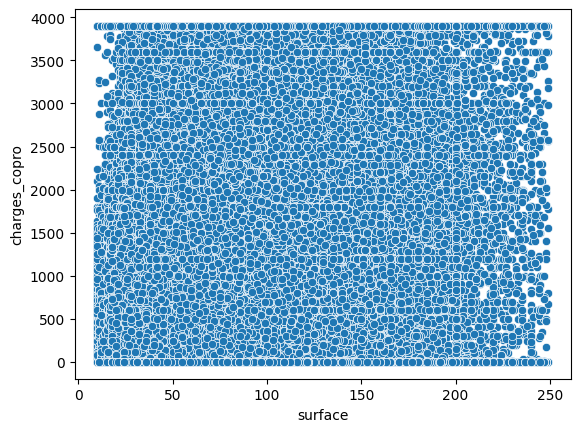

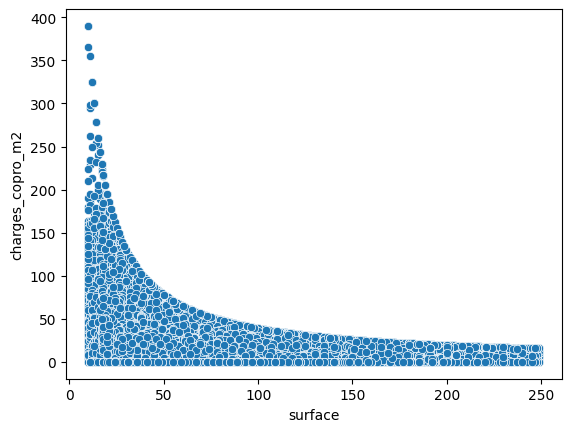

In [38]:
# charges copro
threshold=0.95
column="charges_copro"
print (df[column].value_counts(dropna=False,normalize=True))
if MediumPlotActive :
    sns.scatterplot(y=df["prix_m2_vente"],x=df[column])
    plt.show()
df.loc[:,column] = df[column].clip(upper=df[column].quantile(threshold))
if MediumPlotActive :
    sns.scatterplot(y=df["prix_m2_vente"],x=df[column])
    plt.show()
print (df[column].median())
df[column]= df[column].fillna(0)

sns.scatterplot(y=df[column],x=df["surface"])
plt.show()

df["charges_copro_m2"] = df[column] /df["surface"]
sns.scatterplot(y=df["charges_copro_m2"],x=df["surface"])

charges_copro_hist= pd.cut(df.charges_copro,np.arange(0,20000,5000))



In [39]:
#  remove Nan values for numerical columns
columns = df.select_dtypes(include='number').columns.tolist()
print (df[columns].isna().sum())

etage                           0
surface                         0
nb_pieces                       0
prix_bien                       0
balcon                          0
eau                             0
bain                            0
dpeC                       679453
mapCoordonneesLatitude          0
mapCoordonneesLongitude         0
nb_etages                       0
places_parking                  0
annee_construction              0
nb_toilettes                    0
nb_terraces                     0
surface_balcon                  0
nb_logements_copro              0
charges_copro                   0
logement_neuf                   0
CODE_IRIS                       0
REG                             0
DEP                             0
loyer_m2_median_n7          48098
nb_log_n7                   48098
taux_rendement_n7           48098
prix_m2_vente                   0
charges_copro_m2                0
dtype: int64


In [40]:
column="dpeC"
threshold=.99
print (df[column].value_counts(dropna=False,normalize=True))
fig = plt.figure(figsize=(12,8))
df.loc[:,column].fillna(0)
if MediumPlotActive :
    sns.scatterplot(y=df[column],x=df["dpeL"])
    plt.show()
result = df.groupby("dpeL")[column].mean()
print (result)
if MediumPlotActive :
    fig = plt.figure(figsize=(12,8))
    sns.lineplot(y=result.values,x=result.index)
    plt.ylabel("DpeC")
    plt.title("DpeC versus dpeL")
    plt.show()

dpeC
NaN       3.270570e-01
51.00     1.033321e-02
0.00      1.006943e-02
48.00     8.177230e-03
573.00    6.757719e-03
              ...     
175.11    4.813533e-07
489.43    4.813533e-07
149.23    4.813533e-07
168.64    4.813533e-07
197.67    4.813533e-07
Name: proportion, Length: 7305, dtype: float64
dpeL
'                             NaN
0                        4.266715
856                           NaN
A                       40.837754
A kWh/m².year                 NaN
B                       68.308189
Blank                         NaN
C                      130.964568
C kWh/m².year                 NaN
D                      199.712680
D - 231 kWh/m².year           NaN
D kWh/m².year                 NaN
D-218 kWh/m².year             NaN
E                      280.593684
E kWh/m².year          293.000000
F                      373.697217
G                      501.300871
NS                     217.287479
VI                     293.873665
Name: dpeC, dtype: float64


<Figure size 1200x800 with 0 Axes>

loyer_m2_median_n7
17.65    21494
12.07    20855
16.67    18348
13.56    18072
19.44    16294
         ...  
3.22         1
25.53        1
33.00        1
41.11        1
34.31        1
Name: count, Length: 2504, dtype: int64
nb_log_n7
1.0        25016
2.0        20033
18978.0    19737
5340.0     18553
3.0        17055
           ...  
430.0        124
379.0        118
564.0         94
460.0         88
561.0         70
Name: count, Length: 924, dtype: int64
taux_rendement_n7
0.038    59381
0.037    59249
0.039    58608
0.036    58524
0.040    57405
         ...  
0.354        1
0.268        1
0.335        1
0.461        1
0.305        1
Name: count, Length: 426, dtype: int64


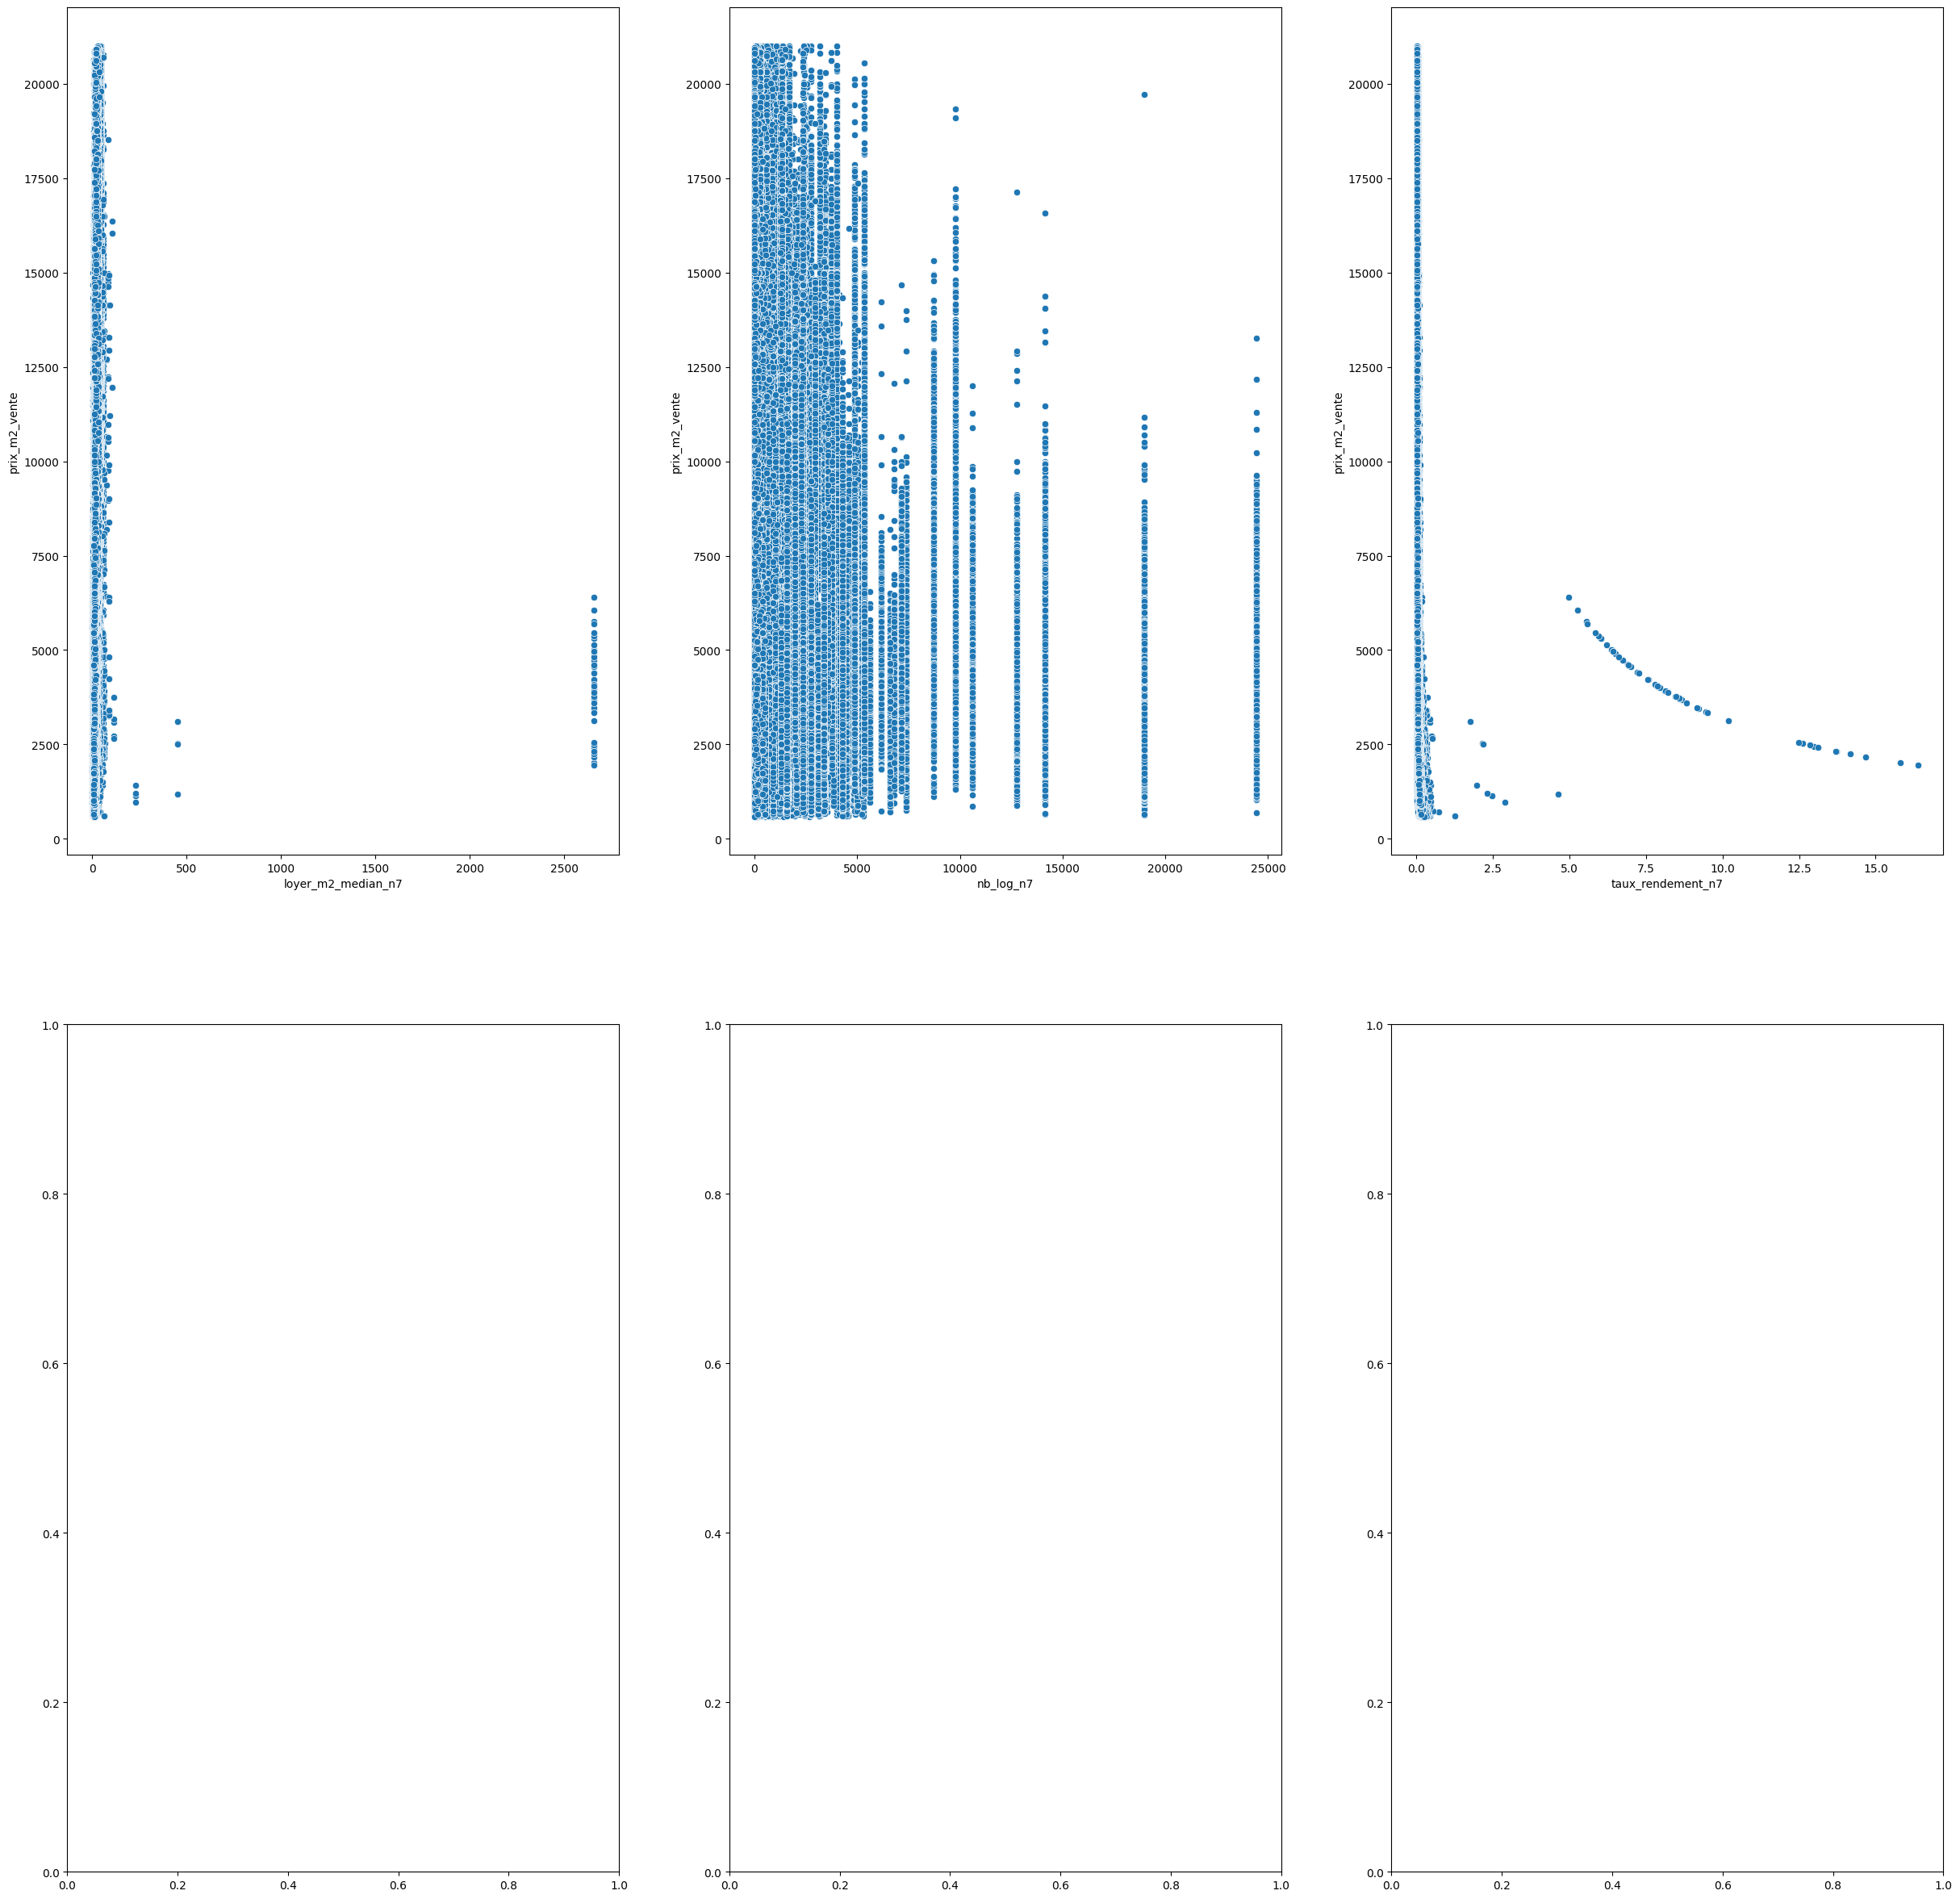

In [41]:
columns = ['loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7']
for column in columns :
    print (df[column].value_counts())
SmallPlotActive = True

if SmallPlotActive :
    index = 0
    ncols=3
    nrows = int(len(columns)/ncols) +1
    fig , axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30,15*nrows))

    for column in columns :
        sns.scatterplot(ax=axes[int(index/ncols),index%ncols],y=df["prix_m2_vente"],x=df[column])
        index = index +1

    plt.show()

for column in columns :
    df[column] = df[column].fillna(df[column].median())

In [42]:
#  print numercial Nan
print_dataframe_isna(df,type=ColumnType.NUMERICAL)

                         missing values  percent_missing
dpeC                             679453        32.705697
surface                               0         0.000000
etage                                 0         0.000000
nb_pieces                             0         0.000000
prix_bien                             0         0.000000
eau                                   0         0.000000
balcon                                0         0.000000
bain                                  0         0.000000
mapCoordonneesLatitude                0         0.000000
mapCoordonneesLongitude               0         0.000000
nb_etages                             0         0.000000
places_parking                        0         0.000000
annee_construction                    0         0.000000
nb_toilettes                          0         0.000000
nb_terraces                           0         0.000000
surface_balcon                        0         0.000000
nb_logements_copro             

## Process categorial columns

In [43]:
# display unique values for categorial columns for analysis

columns_categorial = df.select_dtypes(include="object").columns.tolist()
for column in columns_categorial:
    print(f"{column}: {df[column].unique()}")

typedebien: ['a']
dpeL: ['D' 'C' 'E' 'NS' '0' 'F' 'VI' 'B' 'G' 'A' 'D - 231 kWh/m².year' 'Blank'
 'D-218 kWh/m².year' 'E kWh/m².year' 'D kWh/m².year' 'C kWh/m².year'
 'A kWh/m².year' "'" '856']
annonce_exclusive: ['Oui' 'Non' '0']
parking: [None True False]
cave: [False True None]
exposition: ['0' 'Sud-Est' 'Sud' 'Est' 'SO' 'Ouest' 'E, S' 'Nord-Ouest' 'Nord-Sud'
 'traversant' 'Sud-Ouest' 'sud-ouest' 'Nord' 'Est-Ouest'
 'traversant nord-sud' 'sud-est' 'Nord-Est' 'OUEST' 'Traversant-Est-Ouest'
 'Nord Sud Est' 'SUD' 'SUD OUEST' 'Nord Sud Est Ouest' 'Nord-ouest'
 'Sud-Est-Ouest' 'nord-est / sud-ouest' 'EST SUD OUEST' 'SUD EST'
 'nord-ouest / sud-est' 'Nord Sud Ouest' 'NO' 'Nord-est' 'sud est'
 'sud,ouest' 'NS' 'EST' 'Sud Ouest  Nord Ouest' 'nord,est' 'nord,ouest'
 'sud,est' 'SUD Ouest' 'NE' 'nord,sud' 'Sud et Est' 'Sud/Est' 'Sud/Ouest'
 'Nord/Ouest' 'Nord Est Ouest' 'S/E' 'est / ouest' 'N' 'ON' 'SE/SO'
 'EST / OUEST' 'Est Sud' 'Suid Ouest' 'Ouest Sud' 'OUEST / SUD'
 'sud ouest' 'OUET' 'Sud

['D' 'C' 'E' 'NS' '0' 'F' 'VI' 'B' 'G' 'A' 'D - 231 kWh/m².year' 'Blank'
 'D-218 kWh/m².year' 'E kWh/m².year' 'D kWh/m².year' 'C kWh/m².year'
 'A kWh/m².year' "'" '856']
0
dpeL
D                      521628
0                      316858
E                      308705
C                      301526
NS                     180295
VI                     134362
B                       97671
F                       94764
A                       73335
G                       48289
Blank                      21
D kWh/m².year               6
E kWh/m².year               6
A kWh/m².year               3
C kWh/m².year               3
D - 231 kWh/m².year         1
D-218 kWh/m².year           1
'                           1
856                         1
Name: count, dtype: int64


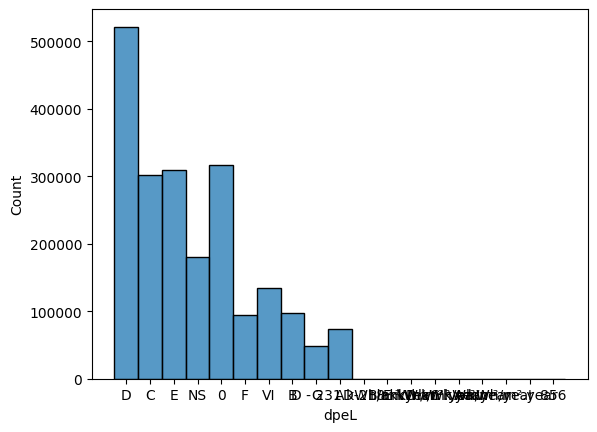

<Figure size 1600x800 with 0 Axes>

dpeL
D          521636
0          316858
E          308711
C          301529
NS         180295
F/G        134362
B           97671
F           94764
A           73338
G           48289
Unknown        23
Name: count, dtype: int64


/tmp/ipykernel_3209/275408383.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['dpeL_num'] = df['dpeL'].replace(to_replace=dpe_ranking,value = dpe_ranking_num)


dpeL
D          521636
0          316858
E          308711
C          301529
NS         180295
F/G        134362
B           97671
F           94764
A           73338
G           48289
Unknown        23
Name: count, dtype: int64


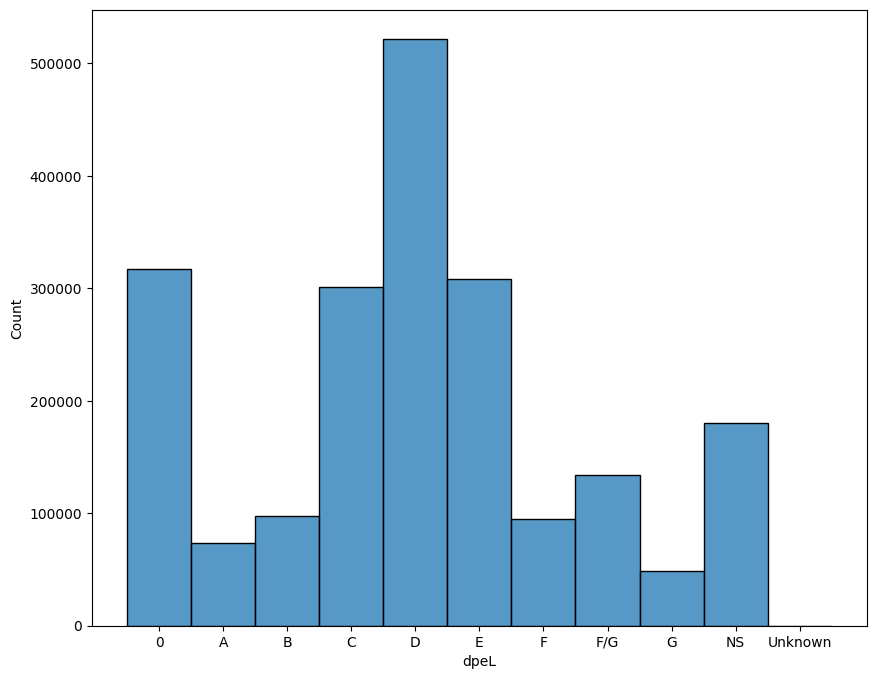

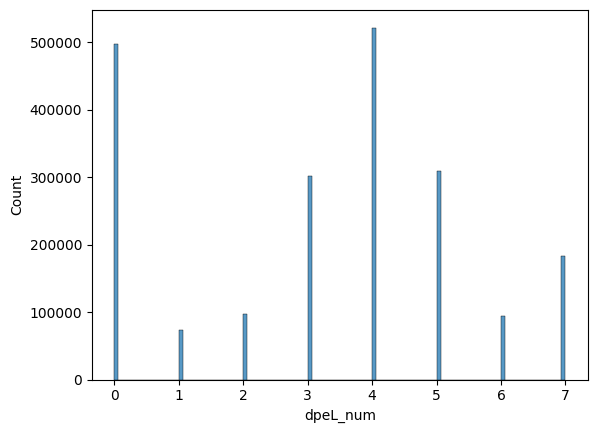

In [44]:
#  Process dpel
#  NS means non significative
# how to take into account dpe zero ?
print(df["dpeL"].unique())
print(df["dpeL"].isna().sum())
print(df["dpeL"].value_counts())

if SmallPlotActive :
    sns.histplot(df["dpeL"])
    plt.figure(figsize=(16,8))
    plt.show()

df["dpeL"] = df["dpeL"].fillna("Unknown")

df["dpeL"] = df["dpeL"].replace(to_replace=["D - 231 kWh/m².year","D-218 kWh/m².year","Blank",'0 kWh/m².year'],value=["D","D","Unknown","0"])
df["dpeL"] = df["dpeL"].replace(to_replace=["E kWh/m².year","D kWh/m².year","C kWh/m².year","A kWh/m².year","856","'"],value=["E","D","C","A","Unknown","Unknown"])

df["dpeL"] = df["dpeL"].replace(to_replace=["VI"],value=["F/G"])
print(df["dpeL"].value_counts())


df['dpeL_num'] = df['dpeL'].replace(to_replace=dpe_ranking,value = dpe_ranking_num)

df['dpeL'] = pd.Categorical(df['dpeL'], dpe_ranking)
print(df["dpeL"].value_counts())

if SmallPlotActive :
    plt.figure(figsize=(10,8))
    sns.histplot(df["dpeL"])
    plt.show()
    sns.histplot(df["dpeL_num"])

ges_class
B                        341396
C                        298844
D                        250108
A                        215207
E                        184739
VI                       137721
NS                        71033
F                         65769
G                         32229
Blank                        29
B kg CO2/m².year             10
A kg CO2/m².year             10
0 kg CO2/m².year              6
F kg CO2/m².year              2
D - 49 kg CO2/m².year         1
E-41 kg CO2/m².year           1
E kg CO2/m².year              1
D kg CO2/m².year              1
C kg CO2/m².year              1
Name: count, dtype: int64


/tmp/ipykernel_3209/2848423494.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ges_class_num'] = df['ges_class'].replace(to_replace=dpe_ranking,value = dpe_ranking_num)
/tmp/ipykernel_3209/2848423494.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['ges_class_num'] = df['ges_class'].replace(to_replace=dpe_ranking,value = dpe_ranking_num)


ges_class
Unknown    551436
B          341406
C          298845
D          250110
A          215217
E          184741
F/G        137721
F           65771
G           32229
0               0
Name: count, dtype: int64


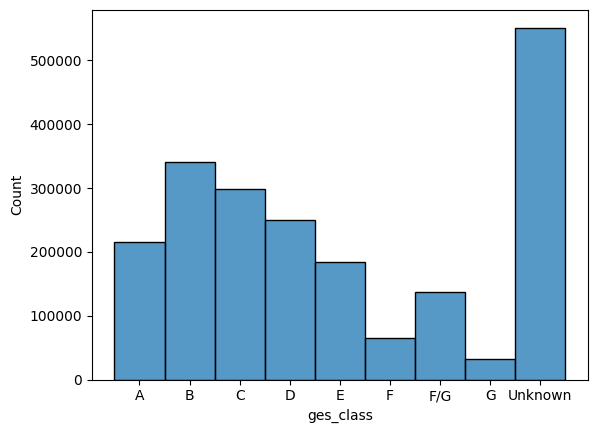

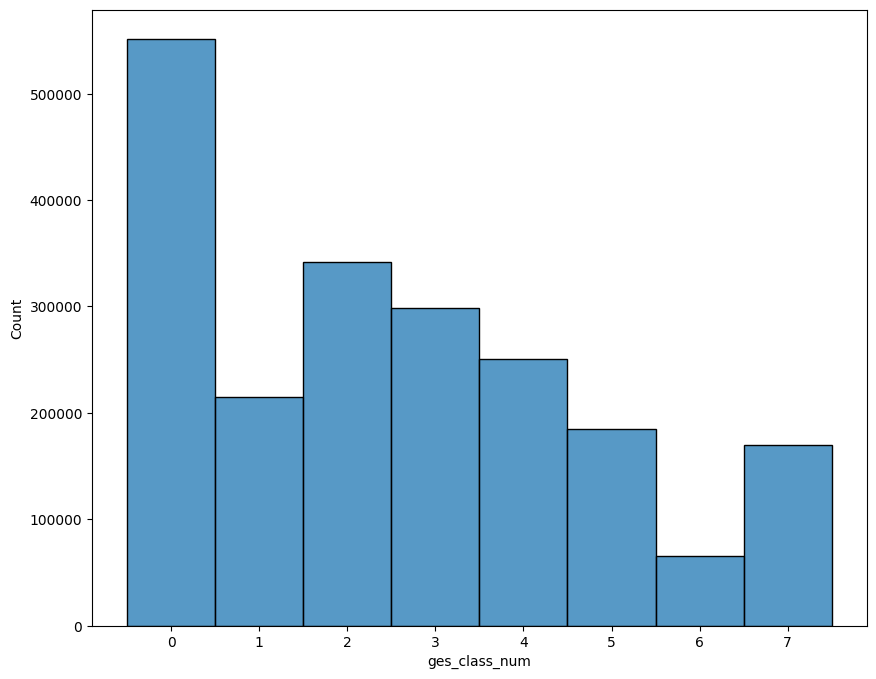

In [45]:
# process categorial ges_class : gaz a effet de serre : set to unknown
print(df["ges_class"].value_counts())

df["ges_class"] = df["ges_class"].fillna("Unknown")

df["ges_class"] = df["ges_class"].replace(to_replace=["D - 49 kg CO2/m².year","E-41 kg CO2/m².year","Blank","0 kg CO2/m².year"],value=["D","E","Unknown","Unknown"])
df["ges_class"] = df["ges_class"].replace(to_replace=["VI"],value=["F/G"])
df["ges_class"] = df["ges_class"].replace(to_replace=["A kg CO2/m².year","E kg CO2/m².year","B kg CO2/m².year","C kg CO2/m².year","D kg CO2/m².year","F kg CO2/m².year","NS"],value=["A","E","B","C","D","F","Unknown"])
df['ges_class'] = pd.Categorical(df['ges_class'], ['0','A','B','C','D','E','F','F/G','G','Unknown'])

df['ges_class_num'] = df['ges_class'].replace(to_replace=dpe_ranking,value = dpe_ranking_num)

print(df["ges_class"].value_counts())

if SmallPlotActive :
    sns.histplot(df["ges_class"])
    plt.show()
    plt.figure(figsize=(10,8))
    sns.histplot(df["ges_class_num"])


In [46]:
# annon exclusive
print(df["annonce_exclusive"].value_counts())
df["annonce_exclusive"] = df["annonce_exclusive"].replace(to_replace=['Oui','Non','0'],value=[1,0,2]).astype(int)


annonce_exclusive
Non    979433
Oui    826067
0      271976
Name: count, dtype: int64


/tmp/ipykernel_3209/136362253.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["annonce_exclusive"] = df["annonce_exclusive"].replace(to_replace=['Oui','Non','0'],value=[1,0,2]).astype(int)


cave
True     523525
False    398436
Name: count, dtype: int64


/tmp/ipykernel_3209/489801147.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace=[np.nan,False,True],value=[0,0,1])


ascenseur
True     831271
False    577974
Name: count, dtype: int64


/tmp/ipykernel_3209/489801147.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace=[np.nan,False,True],value=[0,0,1])


porte_digicode
True     357780
False    305811
Name: count, dtype: int64


/tmp/ipykernel_3209/489801147.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace=[np.nan,False,True],value=[0,0,1])


videophone
True     33411
False     7710
Name: count, dtype: int64


/tmp/ipykernel_3209/489801147.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace=[np.nan,False,True],value=[0,0,1])


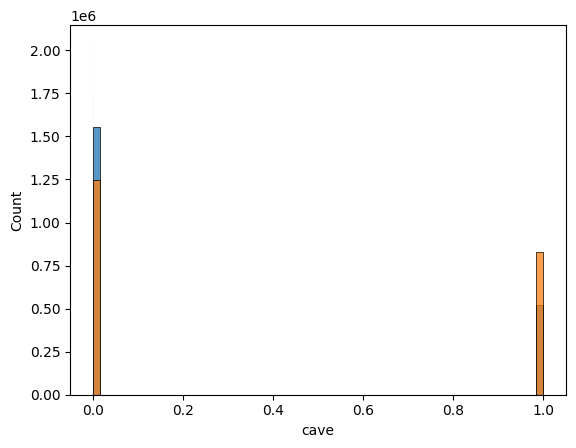

In [47]:
# ascenceur, digicode , cave
columns = ["cave","ascenseur","porte_digicode","videophone"]
for column in columns : 
    print(df[column].value_counts())
    df[column] = df[column].replace(to_replace=[np.nan,False,True],value=[0,0,1])

    if SmallPlotActive :
        sns.histplot(df[column])


chauffage_energie
Électrique                 525562
Gaz                        519582
Fioul                       23092
Bois                         1367
Gaz, Électrique               931
Électrique, Bois              660
Gaz, Bois                     229
Fioul, Électrique              58
Fioul, Bois                    33
Gaz, Fioul                     31
Bois, Électrique               20
Bois, Fioul                    15
Électrique, Fioul              13
Gaz, Électrique, Bois           5
Bois, Fioul, Électrique         2
Électrique, Fioul, Bois         1
Électrique, Bois, Fioul         1
Name: count, dtype: int64
['fioul' 'gaz' 'elec' 'unknown' 'elec,bois' 'gaz,bois' 'bois' 'gaz,elec'
 'bois,elec' 'fioul,bois' 'fioul,elec' 'gaz,fioul' 'bois,fioul'
 'gaz,elec,bois' 'elec,fioul' 'elec,fioul,bois' 'elec,bois,fioul'
 'bois,fioul,elec']
chauf_energy_gaz
chauf_energy_gaz
0    1556698
1     520778
Name: count, dtype: int64
chauf_energy_elec
chauf_energy_elec
0    1550223
1     527253
Name: c

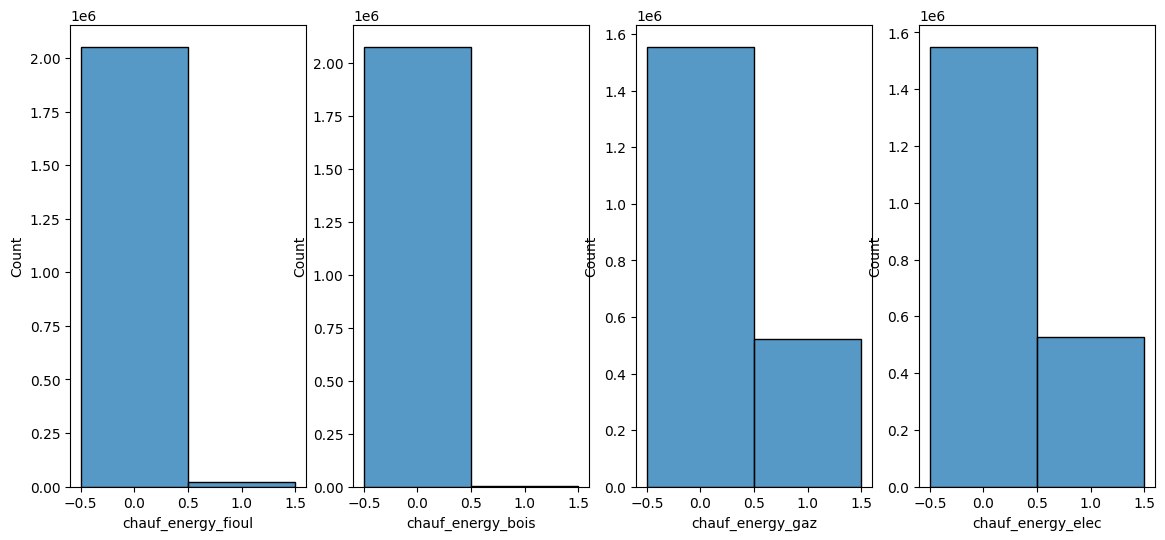

In [48]:
print(df["chauffage_energie"].value_counts())
df["chauffage_energie"] = df["chauffage_energie"].fillna("unknown")


df['chauffage_energie'] = df['chauffage_energie'].str.lower()
df['chauffage_energie'] = df['chauffage_energie'].replace(to_replace=[", "," ,",","],value=[",",",",","],regex=True)
df["chauffage_energie"] = df["chauffage_energie"].replace(to_replace=["électrique"],value=["elec"],regex=True)
print(df["chauffage_energie"].unique())

#  create sub-categories
energies = ["gaz","elec","bois","fioul"]
for energy in energies :
    target = "chauf_energy_" + energy
    print(target)
    df[target] = df["chauffage_energie"].apply(lambda x : 1 if energy in x else 0)
    print (df[target].value_counts())

for energy in energies :
#  simplify chauffage-energie to first value
    df["chauffage_energie"] = df["chauffage_energie"].apply(lambda x : energy if x.startswith(energy) else x)

# df['chauffage_energie'] = pd.Categorical(df['chauffage_energie'], energies)

if MediumPlotActive :
    plt.figure(figsize=(14,8))
    sns.histplot(df["chauffage_energie"])

if SmallPlotActive :
    plt.figure(figsize=(14,6))
    plt.subplot(141)
    sns.histplot(df["chauf_energy_fioul"],discrete=True)
    plt.subplot(142)
    sns.histplot(df["chauf_energy_bois"],discrete=True)
    plt.subplot(143)
    sns.histplot(df["chauf_energy_gaz"],discrete=True)
    plt.subplot(144)
    sns.histplot(df["chauf_energy_elec"],discrete=True)
    plt.show()


chauffage_systeme
Radiateur                                          543841
Convecteur                                          30870
Sol                                                 25012
Climatisation révérsible                            23322
Pompe à chaleur                                     13092
Chaudière                                            3106
Pompe à chaleur, Climatisation révérsible            1290
Poêle à Bois                                          749
Pompe à chaleur, Radiateur                            488
Pompe à chaleur, Sol                                  450
Cheminée                                              369
Radiateur, Chaudière                                  311
Radiateur, Climatisation révérsible                   154
Sol, Radiateur                                        143
Pompe à chaleur, Convecteur                            84
Sol, Convecteur                                        75
Convecteur, Climatisation révérsible                  

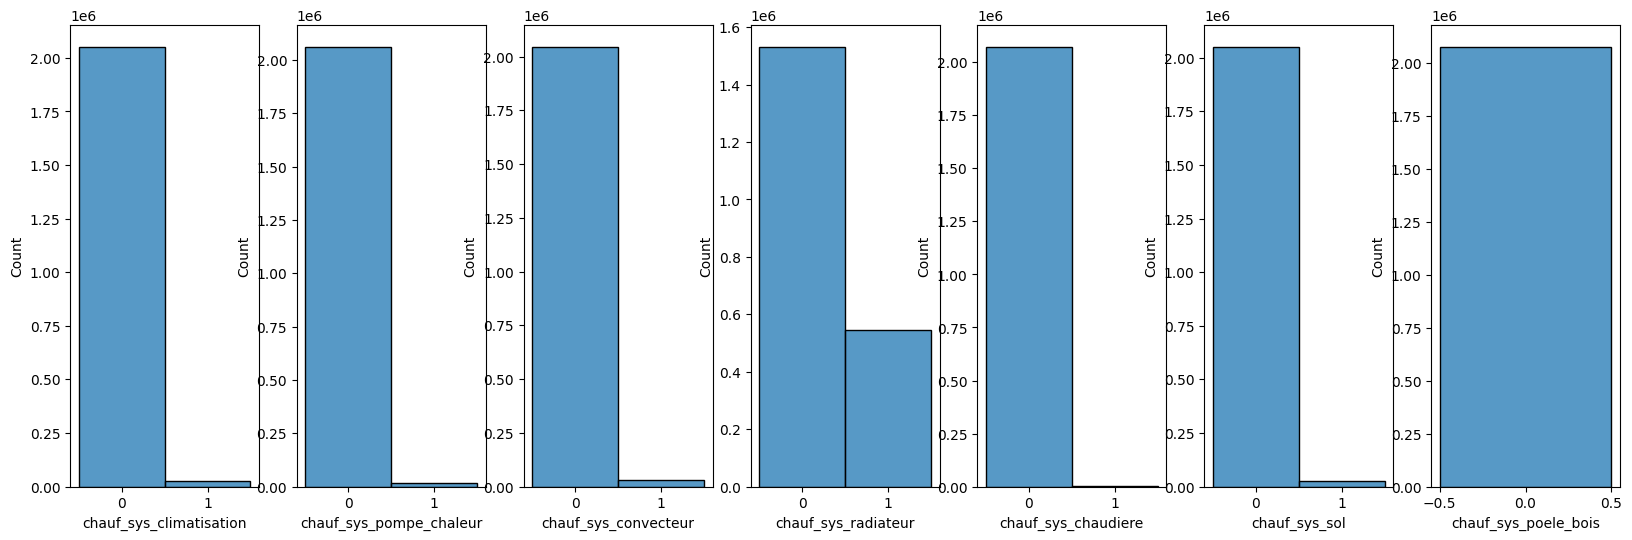

In [49]:
#  chauffage system
print(df["chauffage_systeme"].value_counts())

df["chauffage_systeme"] = df["chauffage_systeme"].fillna("unknown")

df['chauffage_systeme'] = df['chauffage_systeme'].str.lower()
df['chauffage_systeme'] = df['chauffage_systeme'].replace(to_replace=[", "," ,",","],value=[",",",",","],regex=True)

changes = {"fluide caloporteur" :"pompe à chaleur","panneau rayonnant" : "convecteur" }
for  old_name, new_name in changes.items() :
    df["chauffage_systeme"] = df["chauffage_systeme"].apply(lambda x : new_name if old_name in x else x)

#  create sub-categories
energies = ["climatisation","pompe à chaleur","convecteur","radiateur","chaudière","sol","poêle-bois"]
outers = ["climatisation","pompe_chaleur","convecteur","radiateur","chaudiere","sol","poele_bois"]
Chauffage_systeme = []
for energy,outer in zip(energies,outers) :
    target = "chauf_sys_" + outer
    Chauffage_systeme.append(target)
    df[target] = df["chauffage_systeme"].apply(lambda x : 1 if energy in x else 0)
    print (df[target].value_counts())
# sort by decreasing importance


# df['chauffage_systeme'] = pd.Categorical(df['chauffage_systeme'], energies)
if MediumPlotActive :
    energies = ["climatisation révérsible","pompe à chaleur","sol","convecteur","radiateur","chaudière","poêle à bois"]
    for name in energies : 
        df["chauffage_systeme"] = df["chauffage_systeme"].apply(lambda x : name if name in x else x)
    plt.figure(figsize=(8,6))
    sns.histplot(df["chauffage_systeme"])
    plt.xticks(rotation=70)
    plt.show()

if SmallPlotActive :

    plt.figure(figsize=(20,6))

    plt.subplot(171)
    sns.histplot(df["chauf_sys_climatisation"],discrete=True)

    plt.subplot(172)
    sns.histplot(df["chauf_sys_pompe_chaleur"],discrete=True)

    plt.subplot(173)
    sns.histplot(df["chauf_sys_convecteur"],discrete=True)

    plt.subplot(174)
    sns.histplot(df["chauf_sys_radiateur"],discrete=True)

    plt.subplot(175)
    sns.histplot(df["chauf_sys_chaudiere"],discrete=True)
    plt.subplot(176)
    sns.histplot(df["chauf_sys_sol"],discrete=True)
    plt.subplot(177)
    sns.histplot(df["chauf_sys_poele_bois"],discrete=True)

chauffage_mode
Individuel                        816906
Collectif                         360728
Collectif, Central                 13355
Central                             5251
Collectif, Individuel               4880
Individuel, Central                 2707
Collectif, Individuel, Central         4
Name: count, dtype: int64
873645
chauffage_mode
unknown                           873645
individuel                        816906
collectif                         360728
collectif, central                 13355
central                             5251
collectif, individuel               4880
individuel, central                 2707
collectif, individuel, central         4
Name: count, dtype: int64
chauf_mode_individuel
chauf_mode_individuel
0    2052592
1      24884
Name: count, dtype: int64
chauf_mode_collectif
chauf_mode_collectif
0    2061992
1      15484
Name: count, dtype: int64
chauf_mode_central
chauf_mode_central
0    2046324
1      31152
Name: count, dtype: int64
chauffage_mode
u

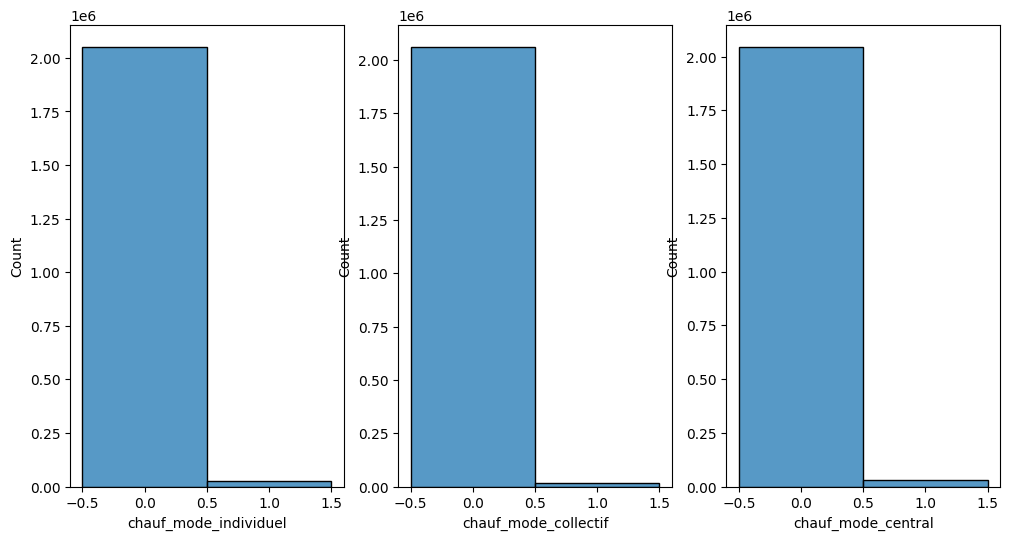

In [50]:
#porcess categorial  chauffage mode, 50% isna
print(df["chauffage_mode"].value_counts())
print(df["chauffage_mode"].isna().sum())
df["chauffage_mode"] = df["chauffage_mode"].fillna("unknown")
df["chauffage_mode"] = df["chauffage_mode"].str.lower()

print(df["chauffage_mode"].value_counts())

outers = ["individuel","collectif","central"]
for energy,outer in zip(energies,outers) :
    target = "chauf_mode_" + outer
    print(target)
    df[target] = df["chauffage_systeme"].apply(lambda x : int(1) if energy in x else int(0))
    print (df[target].value_counts())


# df["chauffage_mode"] = df["chauffage_mode"].apply(lambda x : "Individuel"  if "Individuel" in x else x)
# df["chauffage_mode"] = df["chauffage_mode"].apply(lambda x : "Collectif"  if "Central" in x else x)
print(df["chauffage_mode"].value_counts())

if MediumPlotActive :
    plt.figure(figsize=(8,6))
    sns.histplot(df["chauffage_mode"])
    plt.xticks(rotation=70)
    plt.show()

if SmallPlotActive :
    
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    sns.histplot(df["chauf_mode_individuel"],discrete=True)
    plt.subplot(132)
    sns.histplot(df["chauf_mode_collectif"],discrete=True)
    plt.subplot(133)
    sns.histplot(df["chauf_mode_central"],discrete=True)



exposition
0                 1452517
Sud                158864
Ouest               82720
Est                 70827
Sud-Ouest           57462
                   ...   
sud/ouest/nord          1
SUD et NORD             1
su est                  1
NORD et EST             1
SUD / OUEST             1
Name: count, Length: 463, dtype: int64
expo_double expo_double
0    1800398
1     277078
Name: count, dtype: int64
expo_sud_nord expo_sud_nord
0    2047763
1      29713
Name: count, dtype: int64
expo_est_ouest expo_est_ouest
0    2008963
1      68513
Name: count, dtype: int64


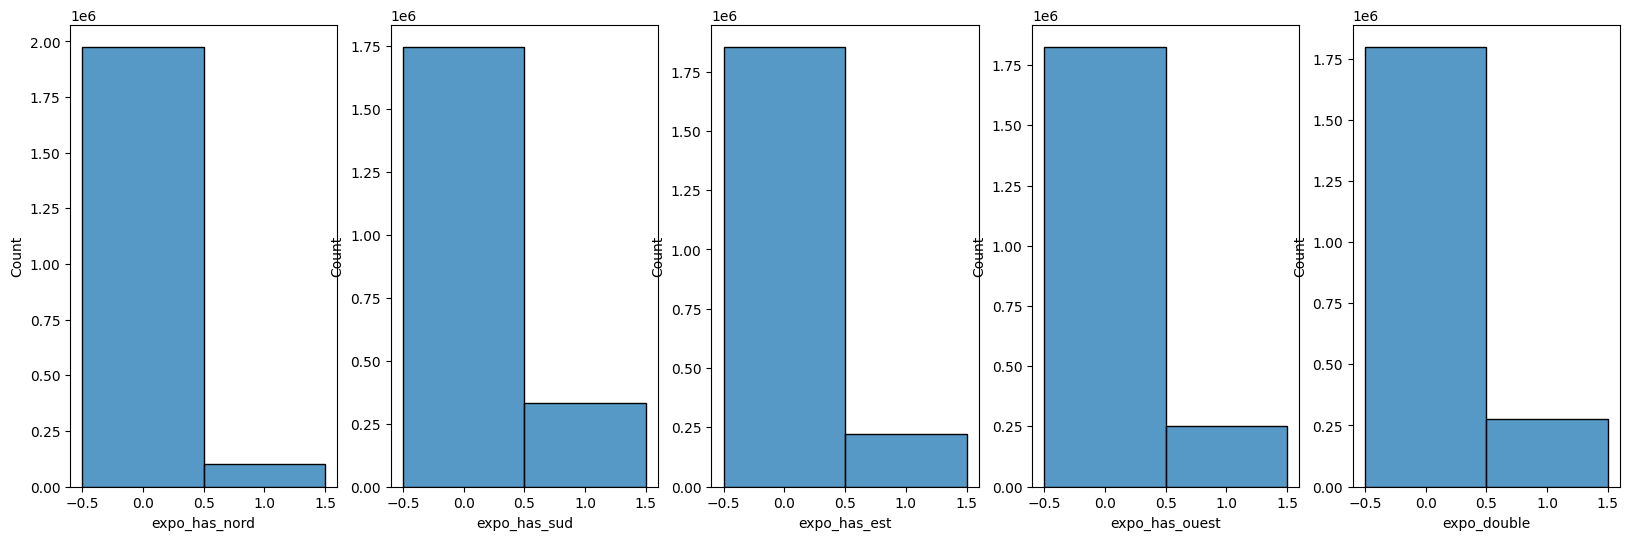

In [51]:
# print (df.exposition.unique())
import re

def encode_exposition_advanced(df):
    """
    Encodage avancé de la colonne exposition pour modèles ML
    """
    # Nettoyage initial 
    df['exposition_clean'] = df['exposition'].astype(str).str.lower()
    df['exposition_clean'] = df['exposition_clean'].str.replace(r'[^\w\s/-]', '', regex=True)
    
    # 1. Variables binaires par direction (ordre important pour éviter les conflits)
    def detect_directions(expo_text):
        """Détection intelligente des directions avec gestion des conflits"""
        if pd.isna(expo_text) or expo_text == 'nan':
            return {'nord': 0, 'sud': 0, 'est': 0, 'ouest': 0}
        
        text = str(expo_text).lower()
        directions = {'nord': 0, 'sud': 0, 'est': 0, 'ouest': 0}

       #Traitement des expositions en mélangeant Nord-Est avec les deux directions nord ET est 
        if re.search(r'\bnord\b', text) :
            directions['nord'] = 1
        if re.search(r'\bsud\b', text) :
            directions['sud'] = 1
        if re.search(r'\best\b', text) :
            directions['est'] = 1
        if re.search(r'\bouest\b', text) :
            directions['ouest'] = 1

        # Gestion des abréviations isolées (plus prudente)
        words = re.sub(r'[-+/]', ' ', text).split()
        for word in words:
            if word == 'n' :
                directions['nord'] = 1
            elif word == 's' :
                directions['sud'] = 1
            elif word == 'e' :
                directions['est'] = 1
            elif word == 'o' :
                directions['ouest'] = 1
        
        return directions
    
    # Application de la détection
    direction_results = df['exposition_clean'].apply(detect_directions)
    for direction in ['nord', 'sud', 'est', 'ouest']:
        df[f'expo_has_{direction}'] = [result[direction] for result in direction_results]

    df.drop("exposition_clean",axis=1,inplace=True)

    # expo double
    df["expo_double"] = 0
    df["expo_sud_nord"] = 0
    df["expo_est_ouest"] = 0

    df.loc[(df.expo_has_nord + df.expo_has_sud + df.expo_has_est + df.expo_has_ouest) >=2,"expo_double"] =1
    df.loc[(df.expo_has_nord + df.expo_has_sud)  ==2,"expo_sud_nord"] =1
    df.loc[(df.expo_has_est + df.expo_has_ouest) ==2,"expo_est_ouest"] =1

print (df.exposition.value_counts())
encode_exposition_advanced(df)
if SmallPlotActive :
    plt.figure(figsize=(20,6))
    plt.subplot(151)
    sns.histplot(df["expo_has_nord"],discrete=True)
    plt.subplot(152)
    sns.histplot(df["expo_has_sud"],discrete=True)
    plt.subplot(153)
    sns.histplot(df["expo_has_est"],discrete=True)
    plt.subplot(154)
    sns.histplot(df["expo_has_ouest"],discrete=True)
    plt.subplot(155)
    sns.histplot(df["expo_double"],discrete=True)

print ("expo_double",df.expo_double.value_counts())
print ("expo_sud_nord",df.expo_sud_nord.value_counts())
print ("expo_est_ouest",df.expo_est_ouest.value_counts())

df.drop(columns=["expo_est_ouest","expo_sud_nord"],inplace=True)


In [52]:
#  process date
df['date'] = pd.to_datetime(df['date'])

In [53]:

print_dataframe_isna(df,type=ColumnType.CATEGORIAL)
print_dataframe_isna(df,type=ColumnType.NUMERICAL)

                   missing values  percent_missing
parking                   2067917        99.539874
typedebien                      0         0.000000
exposition                      0         0.000000
chauffage_energie               0         0.000000
chauffage_systeme               0         0.000000
chauffage_mode                  0         0.000000
                         missing values  percent_missing
dpeC                             679453        32.705697
etage                                 0         0.000000
nb_pieces                             0         0.000000
surface                               0         0.000000
prix_bien                             0         0.000000
balcon                                0         0.000000
eau                                   0         0.000000
bain                                  0         0.000000
mapCoordonneesLatitude                0         0.000000
mapCoordonneesLongitude               0         0.000000
annonce_exclusiv

## Correlations of colums


In [54]:
# exposition
if HeatMapDisplay :
    display_heatmap (df,expositions,"prix_m2_vente")
    display_heatmap (df,expositions,"prix_bien")

In [55]:
# chauffage système
if HeatMapDisplay :
    display_heatmap (df,chauffage_systems, "prix_m2_vente", size=12)
    display_heatmap (df,chauffage_systems, "prix_bien", size=12)


In [56]:
plt.figure(figsize=[15,15])

selection = data=df.select_dtypes(include='number')
selection.drop(columns=["prix_bien","nb_terraces"],inplace=True)

data_subset  = [x for x in selection if x not in chauffage_systems]
data_selection  = [x for x in data_subset if x not in expositions ]

if HeatMapDisplay :
    display_heatmap (df,data_selection,"prix_m2_vente",size=15)


<Figure size 1500x1500 with 0 Axes>

In [57]:
#  spearman correlation on most correlated columns

if SpiermanDisplay :
    display_spearman(df=df,target="prix_bien",drop="prix_m2_vente",threshold=0.10)

    display_spearman(df=df,target="prix_m2_vente",drop="prix_bien",threshold=0.10)


#  # drop columns 

In [58]:
#  drop categorial columns thzt are no more relevant
columns = ["exposition","chauffage_mode","chauffage_systeme","chauffage_energie","dpeL","ges_class","dpeC","typedebien","charges_copro"]
#  remove balcon parking
columns.append ("surface_balcon")
columns.append ("parking")
columns.append ("mapCoordonneesLatitude")
columns.append ("mapCoordonneesLongitude")
df.drop(columns=columns,inplace=True)
#  remove nb_terraces ?

# # save data for Modeling

In [59]:
# save appartement file
display (df)
save_appartement_file(df)

,etage,surface,nb_pieces,prix_bien,balcon,eau,bain,annonce_exclusive,nb_etages,places_parking,...,chauf_sys_sol,chauf_sys_poele_bois,chauf_mode_individuel,chauf_mode_collectif,chauf_mode_central,expo_has_nord,expo_has_sud,expo_has_est,expo_has_ouest,expo_double
idannonce,,,,,,,,,,,,,,,,,,,,,
immo-facile-57743459,0,65,2,136000,0,0,0,1,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0
hektor-369_EXPERTIMO22-191576,1,72,3,369000,0,0,1,0,3.0,2.0,...,1,0,0,0,0,0,1,1,0,1
ag340369-457035236,2,128,5,440000,1,1,1,0,3.0,1.0,...,0,0,0,0,0,0,1,0,0,0
ag743447-458182022,0,76,4,170000,0,1,0,0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
immo-facile-57398283,0,84,3,449000,0,0,0,1,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143384469,1,59,2,202419,0,1,0,2,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
108159685,2,36,2,110000,0,1,0,2,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
141204167,1,97,4,169500,0,0,1,2,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


prix_m2_vente    0
date             0
dtype: int64
prix_m2_vente           float64
date             datetime64[ns]
dtype: object
prix_m2_vente           float64
date             datetime64[ns]
dtype: object


/tmp/ipykernel_3209/606315569.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")


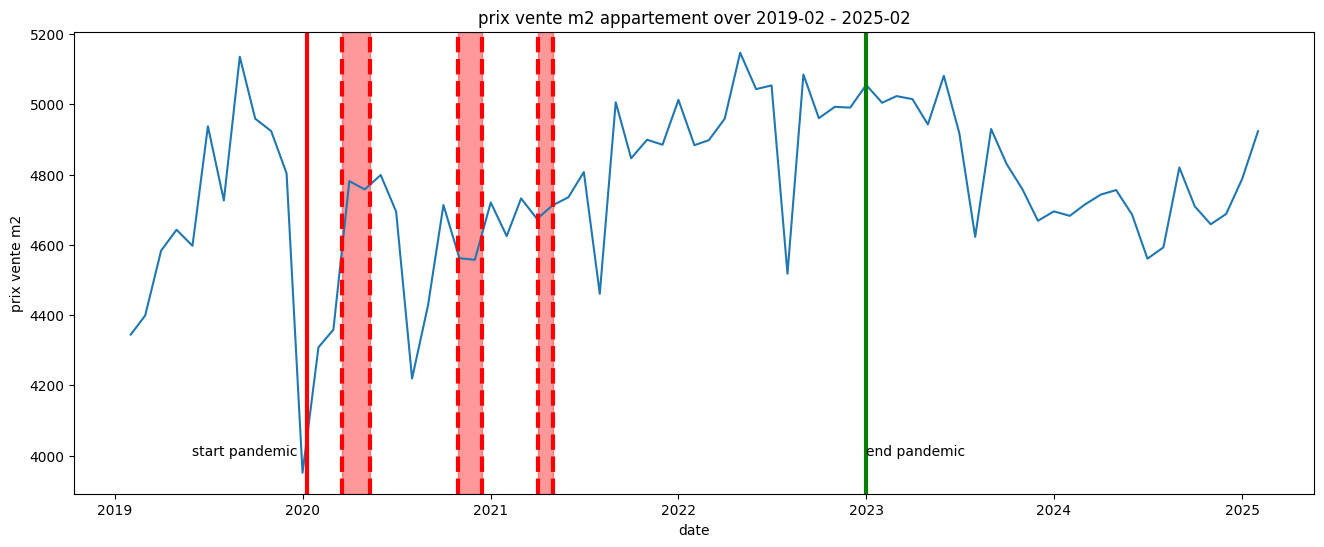

,prix_m2_vente,date
date,,
2024-03-01,4714.382839,2024-03-01
2024-04-01,4742.732233,2024-04-01
2024-05-01,4755.823361,2024-05-01
2024-06-01,4686.135814,2024-06-01
2024-07-01,4560.485236,2024-07-01
2024-08-01,4592.705044,2024-08-01
2024-09-01,4820.095090,2024-09-01
2024-10-01,4709.402383,2024-10-01
2024-11-01,4658.351891,2024-11-01


In [60]:
import datetime

df1 = df[["prix_m2_vente", "date"]]
print (df1.isna().sum())

print (df1.dtypes)
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")
df1 = df1.set_index('date',drop=False)
print (df1.dtypes)
df1 = df1.sort_index(ascending=True)
df2 = df1.resample("MS").mean()
df2 = df2.dropna()

plt.figure(figsize=(16,6))
title = "prix vente m2 appartement over " + df2.index[0].strftime('%Y-%m') + " - " + df2.index[0-1].strftime('%Y-%m')
plt.title (title)
plt.ylabel('prix vente m2')
plt.xlabel('date')
plt.plot(df2.prix_m2_vente)

plt.axvline(datetime.datetime(2020, 1,9 ), color='red', linewidth=3, linestyle='-')
plt.text (datetime.datetime(2019, 6,1 ), 4000.,"start pandemic")

plt.axvline(datetime.datetime(2020, 3,17 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2020, 5,11 ), color='red', linewidth=3, linestyle='--')
plt.axvspan(datetime.datetime(2020, 3,17 ), datetime.datetime(2020, 5,11), color='red',alpha=0.4)

plt.axvline(datetime.datetime(2020, 10,30 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2020, 12,15 ), color='red', linewidth=3, linestyle='--')
plt.axvspan(datetime.datetime(2020, 10,30), datetime.datetime(2020, 12,15), color='red',alpha=0.4)


plt.axvline(datetime.datetime(2021, 4,3 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2021, 5,3 ), color='red', linewidth=3, linestyle='--')
plt.axvspan(datetime.datetime(2021, 4,3), datetime.datetime(2021, 5,3), color='red',alpha=0.4)


plt.axvline(datetime.datetime(2023, 1,1 ), color='green', linewidth=3, linestyle='-')
plt.text (datetime.datetime(2023, 1,1 ), 4000.,"end pandemic")

plt.show()
display (df2.tail(12))

regions quartiles         REG  prix_m2_vente
0.25  27.75    3067.941491
0.50  48.00    3676.919806
0.75  75.25    4118.528443
0.95  88.05    5793.044404


/tmp/ipykernel_3209/4108388618.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_reg.index,y=df_reg.prix_m2_vente,palette='Paired')
/tmp/ipykernel_3209/4108388618.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(region_names,rotation=90)


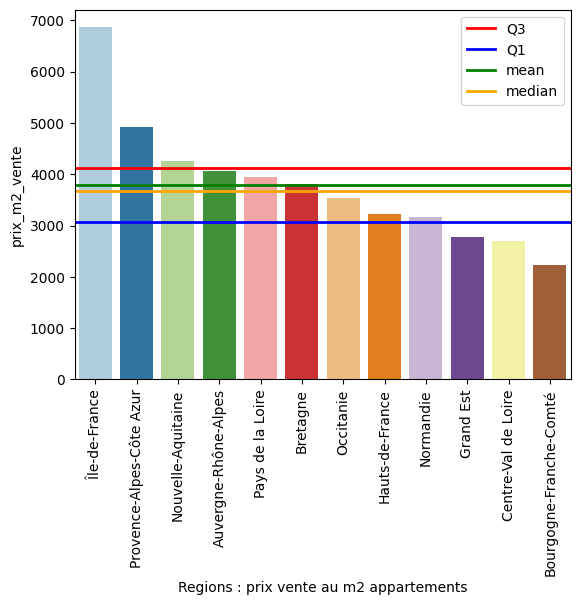

/tmp/ipykernel_3209/4108388618.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dep_names,rotation=90)


Text(0.5, 0, 'Departements : prix vente au m2 appartements')

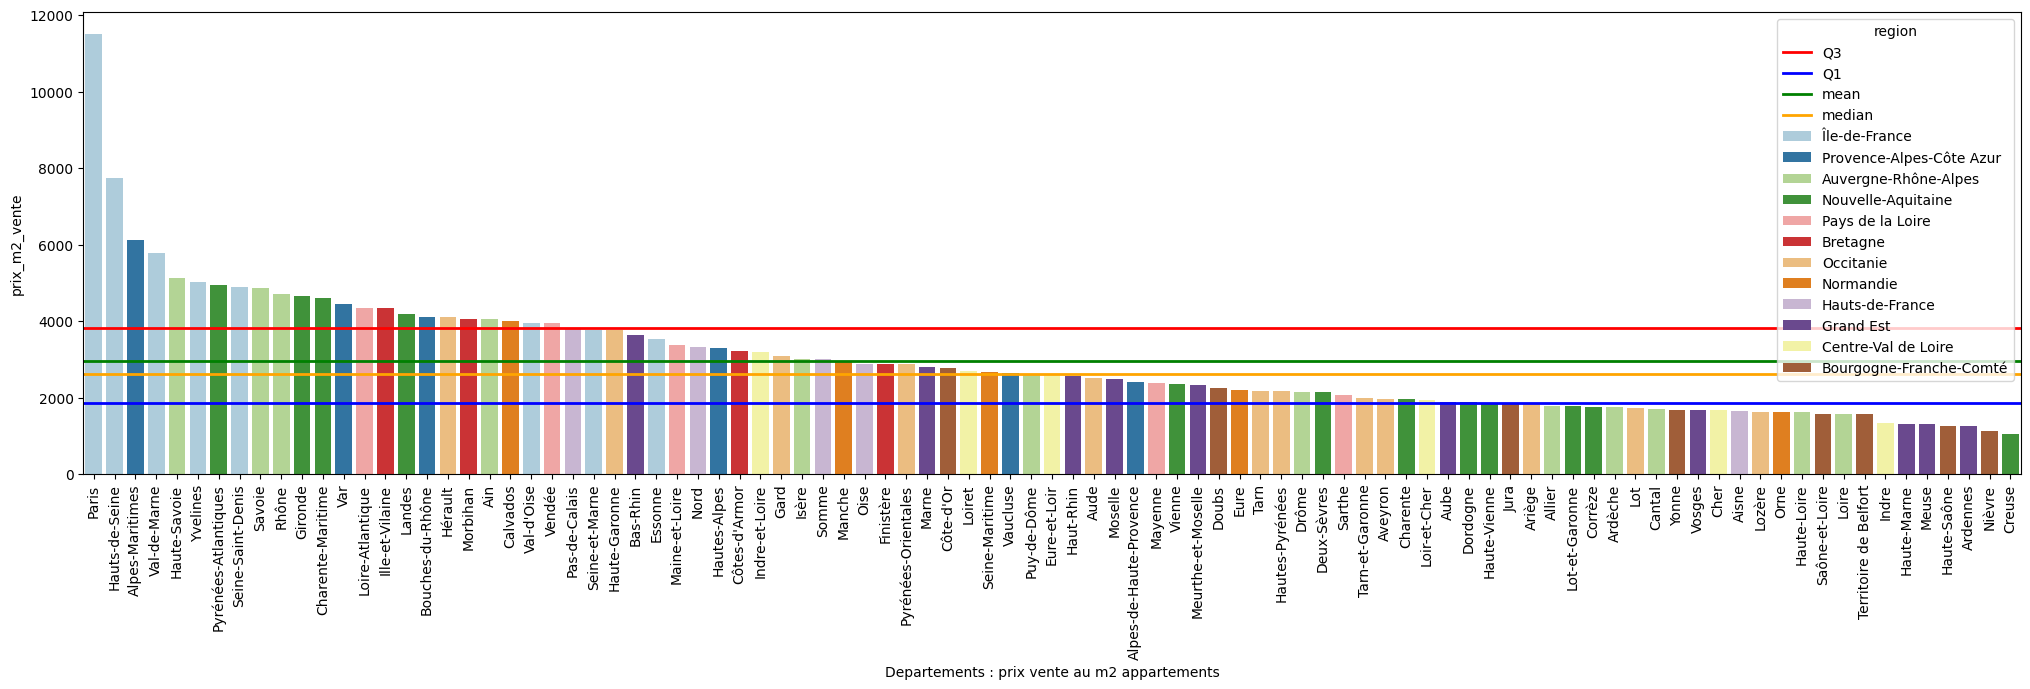

In [ ]:
from regions import REGIONS_CODE,DEPARTMENTS
df_reg = df.groupby(["REG"]).agg(prix_m2_vente = ("prix_m2_vente","mean"))
df_dep = df.groupby(["DEP"]).agg(prix_m2_vente = ("prix_m2_vente","mean"),REG= ("REG","first"))
df_dep = df_dep.sort_values(by="prix_m2_vente",ascending=False).reset_index()
df_reg = df_reg.sort_values(by="prix_m2_vente",ascending=False).reset_index()

reg_quart = df_reg.quantile([.25, 0.5,.75,.95])
print("regions quartiles", df_reg.quantile([.25, 0.5,.75,.95]))
dep_quart = df_dep.quantile([.25, 0.5,.75,.95])
# print("departements quartiles", df_dep.quantile([.25, 0.5,.75,.95]))


region_names = df_reg["REG"].apply ( lambda x : REGIONS_CODE[x])
fig, ax = plt.subplots(figsize=(12,6))
ax.axhline(y=reg_quart["prix_m2_vente"][0.75],color="red", linewidth=2, label="Q3", linestyle='-')
ax.axhline(y=reg_quart["prix_m2_vente"][0.25],color="blue", linewidth=2, label="Q1", linestyle='-')
ax.axhline(y=df_reg["prix_m2_vente"].mean(),color="green", linewidth=2, label="mean", linestyle='-')
ax.axhline(y=df_reg["prix_m2_vente"].median(),color="orange", linewidth=2, label="median", linestyle='-')

sns.barplot(x=df_reg.index,y=df_reg.prix_m2_vente,palette='Paired')
ax.set_xlabel("Regions : prix vente au m2 appartements")
ax.set_xticklabels(region_names,rotation=90)
plt.legend()

if SaveImage :
        save_image(plt,filename="prix_m2_regions",modelname="",dpi=300)
plt.show()


dep_names = df_dep["DEP"].apply ( lambda x : DEPARTMENTS[x])
fig, ax = plt.subplots(figsize=(15, 6))
df_dep["region"] = df_dep["REG"].apply ( lambda x : REGIONS_CODE[x])
ax.axhline(y=dep_quart["prix_m2_vente"][0.75],color="red", linewidth=2, label="Q3", linestyle='-')
ax.axhline(y=dep_quart["prix_m2_vente"][0.25],color="blue", linewidth=2, label="Q1", linestyle='-')
ax.axhline(y=df_dep["prix_m2_vente"].mean(),color="green", linewidth=2, label="mean", linestyle='-')
ax.axhline(y=df_dep["prix_m2_vente"].median(),color="orange", linewidth=2, label="median", linestyle='-')

sns.barplot(y=df_dep["prix_m2_vente"],x=df_dep.index,hue=df_dep["region"],palette='Paired')
ax.set_xticklabels(dep_names,rotation=90)
ax.set_xlabel("Departements : prix vente au m2 appartements")

if SaveImage :
        save_image(plt,filename="prix_m2_departements",modelname="",dpi=300)
plt.show()
